# Comparative study between several capital cities in relation of coffee consumption
#### Manuel Alejandro Londoño Cadavid


## Introduction

In this project, I will do a comparative study of the coffee consumption in several capital cities. The main questions of the study are: Which capitals have the largest number of coffee shops per total population? And, how are related this cities? These two main questions are intended to help a growing brand that wants to expand to a new country and to have high rates of incomes.

Imagine for example that a national or maybe local coffee shop brand wants to expand to a new country and also to have good income rates to justify the investment. So how can we help these brand to overcome such a problem. Let’s say for example that these brand operates mainly in New York. The next step could be to identify a city that relates to New York in relation of coffee consumption and decide whether or not to open a new coffee shop in there. 

Now, how are we going to solve these two questions? First, we have to spend some time capturing geospatial data from coffee shops in several capital cities, for example Paris, Toronto, Berlin, London, and even Bogotá. For these task, we will use the Foursquare API. The data will be then cleaned and analyzed using Python. The main goal is to establish relations between our city cases and finally clarify where is good to open a new coffee shop. 

## Data
Using the Foursquare API’s category search calls, we can obtain data of all coffee shops in the city that we are studying. We have to narrow down our study because of that 2500 calls limit a day. With this data, and the population data for that specific city, we are going to calculate the rate of coffee shop per habitant. 

We are going to suppose in this study that the majority of clients enter the coffee shop to consume coffee related products. Then the calculated rate will give us a perspective of which city consumes the most coffee. Now, with this rank, we are going to evaluate the best options for the brand to open a new coffee shop. This will be done by studying the neighbors of an specific city. Relying in the geospatial data given by the API, we can visualize in a map the density of coffee shops and then make a suggestion in where the coffee shop would be open. 


## Methodology
First we are going to import the needed libraries: pandas for dataframe handling, geopy for retrieving location data, folium for map plotting, beatifulsoup4 for web scraping, sklearn for KMeans clustering, matplotlib to do the bar charts, and, requests to get the venues information.

In [337]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 

from pandas.io.json import json_normalize # tranforming json file into a pandas dataframe library

import folium # plotting library

import json # library to handle JSON files
from bs4 import BeautifulSoup #to scrap web pages
from folium import plugins #show venues by clusters

import geocoder # import geocoder

#to plot histograms
%matplotlib inline
import matplotlib.pylab as plt
from matplotlib import pyplot

# import k-means from clustering stage
from sklearn.cluster import KMeans

Then, we introduce the Foursquare API’s credentials in our code and define our venues limit that are going to be retrieved. 

In [2]:
CLIENT_ID = '###########' # your Foursquare ID
CLIENT_SECRET = '########' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 1C1JD0PTGEJXCUTXMPR3GL5QGCWLJ041J302NEVM2H2RKV3X
CLIENT_SECRET:MUEXEC115P3ZED2MSRCNPF0XWCZFXWPOV2WNGHBPA1DEYA1V


Second we define our key functions that are going to be used around the code. There are two get_nearby_venues functions to get venues information around and entry location. One is going to be used to retrieve venues from Foursquare using an input of search_query, in our case, search_query=’Café’. The other get_nearby_venues retrieves data of all nearby venues information around an specified location. 

In [315]:
def getNearbyVenues(borough, names, latitudes, longitudes, search_query, radius=500):
    venues_list=[]
    for borough, name, lat, lng in zip(borough,names, latitudes, longitudes):
        print(name)

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            lat, 
            lng, 
            VERSION, 
            search_query, 
            radius,
            LIMIT)

        # make the GET request
        results = requests.get(url).json()['response']['venues']

        # return only relevant information for each nearby venue
        venues_list.append([(
            borough,
            name, 
            lat, 
            lng, 
            v['name'], 
            v['location']['lat'], 
            v['location']['lng']) for v in results])

    try:
        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = ['Borough',
                      'Neighborhood', 
                      'Neighborhood Latitude', 
                      'Neighborhood Longitude', 
                      'Venue', 
                      'Venue Latitude', 
                      'Venue Longitude']
    except ValueError:
        pass

    return(nearby_venues)

In [318]:
def getNearbyVenues2(borough,names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for borough,name, lat, lng in zip(borough,names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            borough,
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough',
                             'Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

The functions works retrieving data from the API using as input our credentials, the names of the boroughs and neighborhoods, the location data of every neighbor, the search_query parameter (specific for searching for one venue category), and lastly a radius for limiting the separation distance between the neighbor localization and the venue. Then we used the requests library to download and finally storage the venue data in a dataframe. 

The remaining function for plotting the venues location in a map of the city. For this function is necessary to specify the city name and geocode to center the map and puts a red marker on it. Having this done, the functions captures data from the venues dataframe and adds an entry to the map in a blue marker. To ease the visualization of the map, the plugins library from folium is imported and used to generate visual clusters in the map.

In [65]:
def getvenues_map (name,region, venues_data,zoom):
    #get location data of the city
    address = '{}, {}'.format(name,region)
    geolocator = Nominatim(user_agent="explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    # generate map centred around the desired City
    venues_map=folium.Map(location=[latitude, longitude], zoom_start=zoom)
    
    # add a red circle marker to represent the City's geospatial coordinates
    folium.features.CircleMarker(
        location=[latitude, longitude],
        radius=10,
        color='red',
        popup='New York',
        fill = True,
        fill_color = 'red',
        fill_opacity = 0.6
    ).add_to(venues_map)
    
    #Generate clusters to visualize venues
    venues_clusters=plugins.MarkerCluster().add_to(venues_map)

    # add the Coffee Shops as parts of the clusters
    for lat, lng in zip(venues_data['Venue Latitude'], venues_data['Venue Longitude']):
        folium.Marker(
            location=[lat, lng],
            icon=None,
        ).add_to(venues_clusters)
    

    # display map
    return(venues_map)

## Analysis
Third and last, we download the neighbor’s location data from the IBM servers and put it in different dataframes for the two cities. The two cities are going to be analyzed the same but the data remain separated until the KMeans clustering is used. This is done to ease our analysis and data visualization.

Having the neighbor’s data stored in a dataframe, we call the Foursquare API and retrieve data for coffee shops. Next, we create a map of the city to visualize the venues locations results. With this information, we create a rank of Boroughs with the highest number of coffee shops in order to select and analyze its neighbors. For this, we are going to use bar charts and the group by method in pandas.

With this, we slice our dataframe to include only the borough with the highest coffee shop records and then analyze them visualize them in a map. As our intention is to do a clustering method to categorize similar neighborhoods between these two cities, we have to select the neighbors with the highest number of coffee shops. To do this, we use bar charts in order to do a better slicing in our dataframes. 

When we have selected the scores neighbors, we retrieve venues data from Foursquare for a limit of 100 venues for each neighborhood and store it in a dataframe. We use the get_nearby_venues2 function to do this. After that, we concatenate the new venues dataframes for this cities in one and create a one_hot encoding to transform the venue categories in a boolean variable. It’s important to note that KMeans method need this one_hot encoding codification to work properly.
The cluster label are the added to the main dataframe with also the information about the top venues for each neighborhood. Finally, we can now analyze each cluster to see related neighborhoods in these two cities and suggest the better ones to open a new coffee shop. 



### 1. New York

First we download the data:

In [162]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)['features']

In [163]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
ny_data = pd.DataFrame(columns=column_names)

And then save it in a dataframe:

In [164]:
for data in newyork_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    ny_data = ny_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [165]:
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


Now we can retreive the venues information:

In [10]:
ny_venues=getNearbyVenues(borough=ny_data['Borough'],names=ny_data['Neighborhood'],
                                   latitudes=ny_data['Latitude'],
                                   longitudes=ny_data['Longitude'],
                                  search_query='Café')

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

In [167]:
ny_venues.head()

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
0,Bronx,Wakefield,40.894705,-73.847201,Tropical Cafe,40.900836,-73.846716
1,Bronx,Wakefield,40.894705,-73.847201,Martini Cafe,40.901131,-73.850220
2,Bronx,Co-op City,40.874294,-73.829939,Sangria Cafe,40.869620,-73.828072
3,Bronx,Eastchester,40.887556,-73.827806,Mingles,40.884146,-73.832613
4,Bronx,Riverdale,40.890834,-73.912585,Bagel Corner,40.885895,-73.910959


In [168]:
ny_venues.to_csv(r'ny_venues.csv') #save it to have it in backup

We can visualize the coffee shops in a New York map

In [493]:
getvenues_map(name='New York',region='NY', venues_data=ny_venues,zoom=10)

Let's now count the number of coffee shops per Borough:

In [183]:
ny_venues_grouped=ny_venues[['Borough','Venue']].groupby('Borough').count()
ny_venues_grouped

,Venue
Borough,
Bronx,182
Brooklyn,582
Manhattan,1443
Queens,363
Staten Island,99


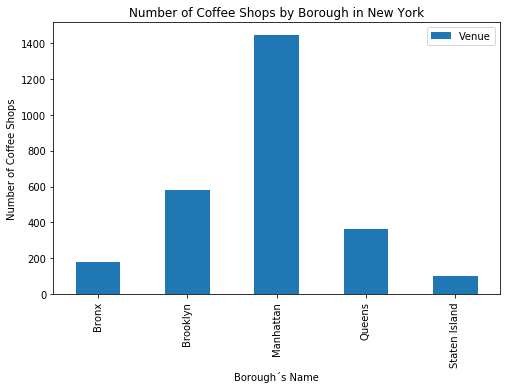

In [184]:
ny_venues_grouped.plot(kind='bar', figsize=(8, 5))

plt.title('Number of Coffee Shops by Borough in New York') # add a title to the histogram
plt.ylabel('Number of Coffee Shops') # add y-label
plt.xlabel('Borough´s Name') # add x-label

plt.show()

And select the highest score from the above chart, i.e. Manhattan. As we see, the distribition reensembles a normal distribution, saying that the coffee shops are spanned almost equally around Manhattan. We now slice our dataframe having records for this Borough only:

In [185]:
ny_venues_manhattan=ny_venues[ny_venues['Borough']=='Manhattan']
ny_venues_manhattan.head()

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
15,Manhattan,Marble Hill,40.876551,-73.91066,Gold Mine Cafe,40.878916,-73.904698
16,Manhattan,Marble Hill,40.876551,-73.91066,cafe frida,40.879607,-73.906606
17,Manhattan,Marble Hill,40.876551,-73.91066,Unity Cafe @ Kingsbridge Center Israel,40.880647,-73.907418
18,Manhattan,Marble Hill,40.876551,-73.91066,Tony's Cafe,40.879178,-73.905299
19,Manhattan,Marble Hill,40.876551,-73.91066,superb gourmet deli cafe,40.879547,-73.904563


Let's create a map to visualize the venues:

In [483]:
getvenues_map(name='Manhattan',region='NY', venues_data=ny_venues_manhattan,zoom=13)

And rank the neighborhoods' coffee shops score:

In [485]:
ny_venues_manhattan_grouped=ny_venues_manhattan[['Neighborhood','Venue']].groupby('Neighborhood').count()

In [486]:
ny_venues_manhattan_grouped=ny_venues_manhattan_grouped[ny_venues_manhattan_grouped['Venue']>10]

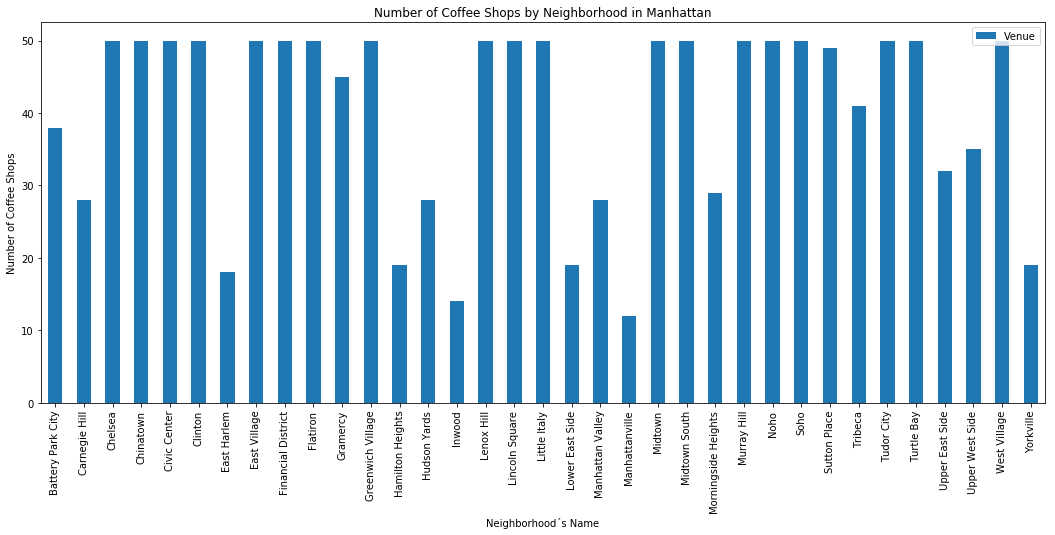

In [487]:
ny_venues_manhattan_grouped.plot(kind='bar', figsize=(18, 7))

plt.title('Number of Coffee Shops by Neighborhood in Manhattan') # add a title to the histogram
plt.ylabel('Number of Coffee Shops') # add y-label
plt.xlabel('Neighborhood´s Name') # add x-label

plt.show()

In this case we don't see any obvious distribution of coffee shops records, we simply select the neighbors with 40 or more coffee shops in order to narrow down our study:

In [205]:
ny_venues_manhattan_grouped=ny_venues_manhattan_grouped[ny_venues_manhattan_grouped['Venue']>40]
ny_venues_manhattan_grouped

,Venue
Neighborhood,
Chelsea,50
Chinatown,50
Civic Center,50
Clinton,50
East Village,50
Financial District,50
Flatiron,50
Gramercy,45
Greenwich Village,50


Now we have to slice our original ny_data dataframe in order to get the venues data for the above neighborhoods:

In [207]:
ny_venues_manhattan_grouped.reset_index(inplace=True)

In [214]:
ny_manhattan_test_list=ny_venues_manhattan_grouped['Neighborhood']

In [210]:
ny_data.set_index('Neighborhood',inplace=True)

In [240]:
ny_manhattan_test=ny_data.loc[[item for item in ny_manhattan_test_list]]
ny_manhattan_test=ny_manhattan_test[ny_manhattan_test['Borough']=='Manhattan']
ny_manhattan_test.reset_index(inplace=True)
ny_manhattan_test

,Neighborhood,Borough,Latitude,Longitude
0,Chelsea,Manhattan,40.744035,-74.003116
1,Chinatown,Manhattan,40.715618,-73.994279
2,Civic Center,Manhattan,40.715229,-74.005415
3,Clinton,Manhattan,40.759101,-73.996119
4,East Village,Manhattan,40.727847,-73.982226
5,Financial District,Manhattan,40.707107,-74.010665
6,Flatiron,Manhattan,40.739673,-73.990947
7,Gramercy,Manhattan,40.737210,-73.981376
8,Greenwich Village,Manhattan,40.726933,-73.999914
9,Lenox Hill,Manhattan,40.768113,-73.958860


We now call the API and store all the venues around the neighborhoods' location to use them in our KMeans clustering method:

In [321]:
ny_manhattan_test_venues=getNearbyVenues2(borough=ny_manhattan_test['Borough'],names=ny_manhattan_test['Neighborhood'],
                                   latitudes=ny_manhattan_test['Latitude'],
                                   longitudes=ny_manhattan_test['Longitude'])

Chelsea
Chinatown
Civic Center
Clinton
East Village
Financial District
Flatiron
Gramercy
Greenwich Village
Lenox Hill
Lincoln Square
Little Italy
Midtown
Midtown South
Murray Hill
Noho
Soho
Sutton Place
Tribeca
Tudor City
Turtle Bay
West Village


In [488]:
ny_manhattan_test_venues.head()

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Manhattan,Chelsea,40.744035,-74.003116,Milk & Hops Chelsea,40.744751,-74.002595,Beer Bar
1,Manhattan,Chelsea,40.744035,-74.003116,Atlantic Theater Company (Linda Gross Theater),40.743953,-74.001476,Theater
2,Manhattan,Chelsea,40.744035,-74.003116,Bathtub Gin,40.743638,-74.003290,Speakeasy
3,Manhattan,Chelsea,40.744035,-74.003116,TAO Downtown,40.742545,-74.003837,Asian Restaurant
4,Manhattan,Chelsea,40.744035,-74.003116,Dil-e Punjab Deli,40.744845,-74.002528,Indian Restaurant


### 1.2. Toronto

Using the same methodology, we first download the neighborhood location data for Toronto:

In [247]:
toronto_html=requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup=BeautifulSoup(toronto_html,'lxml')
#print(soup.prettify())
table = soup.table#find('table', class_='wikitable sortable')
#print(table.prettify())

In [272]:
column_names=['PostalCode','Borough','Neighborhood']
to_data=pd.DataFrame(columns=column_names)
for row in table.find_all('tr'):
    #print(row.prettify())
    row_text=row.text
    column=row_text.split('\n')
    PostalCode=column[1]
    Borough=column[2]
    Neighborhood=column[3]
    to_data=to_data.append({'PostalCode':PostalCode,'Borough':Borough,'Neighborhood':Neighborhood}, ignore_index=True)

In [273]:
to_data.drop(0, inplace=True)
to_data.reset_index(drop=True,inplace=True)

In [274]:
to_data.replace('Not assigned', np.nan, inplace=True)
to_data.reset_index(drop=True,inplace=True)
to_data.head()

,PostalCode,Borough,Neighborhood
0,M1A,NaN,NaN
1,M2A,NaN,NaN
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


In [275]:
to_data.dropna(subset=['Borough'],axis=0,inplace=True)
to_data.reset_index(drop=True,inplace=True)
to_data.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M5A,Downtown Toronto,Regent Park
4,M6A,North York,Lawrence Heights


In [276]:
to_data['Neighborhood'].replace(np.nan, 'Queen\'s Park',inplace=True)

In [277]:
to_data['Neighborhood'].replace(np.nan, 'Queen\'s Park',inplace=True)

In [281]:
to_data=to_data.groupby(['PostalCode','Borough'], as_index=False,sort = True).agg(lambda x: ','.join(x))
to_data.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge,Malvern"
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union"
2,M1E,Scarborough,"Guildwood,Morningside,West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [282]:
df1=pd.read_csv('http://cocl.us/Geospatial_data')
df1.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [283]:
to_data['Latitude']=df1['Latitude']
to_data['Longitude']=df1['Longitude']
to_data.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


And now, we get and store the coffee shops venues information:

In [51]:
to_venues=getNearbyVenues(borough=to_data['Borough'],names=to_data['Neighborhood'],
                                   latitudes=to_data['Latitude'],
                                   longitudes=to_data['Longitude'],
                                  search_query='Café')

Rouge,Malvern
Highland Creek,Rouge Hill,Port Union
Guildwood,Morningside,West Hill
Woburn
Cedarbrae
Scarborough Village
East Birchmount Park,Ionview,Kennedy Park
Clairlea,Golden Mile,Oakridge
Cliffcrest,Cliffside,Scarborough Village West
Birch Cliff,Cliffside West
Dorset Park,Scarborough Town Centre,Wexford Heights
Maryvale,Wexford
Agincourt
Clarks Corners,Sullivan,Tam O'Shanter
Agincourt North,L'Amoreaux East,Milliken,Steeles East
L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview,Henry Farm,Oriole
Bayview Village
Silver Hills,York Mills
Newtonbrook,Willowdale
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Flemingdon Park,Don Mills South
Bathurst Manor,Downsview North,Wilson Heights
Northwood Park,York University
CFB Toronto,Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Woodbine Gardens,Parkview Hill
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The Danforth West,Riverdale
The Beaches West,Indi

In [257]:
to_venues.head()

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
0,Scarborough,Cedarbrae,43.773136,-79.239476,Gerhard's Cafe,43.775859,-79.241871
1,Scarborough,Cedarbrae,43.773136,-79.239476,Family Tree House Café,43.776736,-79.241600
2,Scarborough,Cedarbrae,43.773136,-79.239476,Coffee Culture,43.776278,-79.234026
3,Scarborough,Scarborough Village,43.744734,-79.239476,Tumbe Cafe,43.744058,-79.244021
4,Scarborough,"East Birchmount Park,Ionview,Kennedy Park",43.727929,-79.262029,Papa J's DOGHOUSE CAFÉ & EATERY,43.725189,-79.264633


Let's create a map to visualize them better:

In [258]:
to_venues.to_csv(r'to_venues.csv')

In [489]:
getvenues_map(name='Toronto',region='CA', venues_data=to_venues,zoom=10)

Then we rank up the Boroughs:

In [259]:
to_venues_grouped=to_venues[['Borough','Venue']].groupby('Borough').count()
to_venues_grouped

,Venue
Borough,
Central Toronto,24
Downtown Toronto,476
East Toronto,22
East York,5
Etobicoke,6
North York,33
Queen's Park,23
Scarborough,11
West Toronto,36


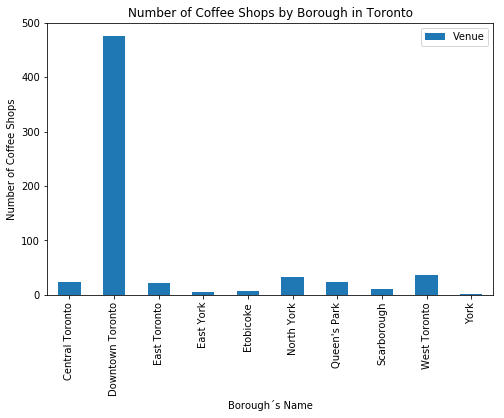

In [260]:
to_venues_grouped.plot(kind='bar', figsize=(8, 5))

plt.title('Number of Coffee Shops by Borough in Toronto') # add a title to the histogram
plt.ylabel('Number of Coffee Shops') # add y-label
plt.xlabel('Borough´s Name') # add x-label

plt.show()

As we see from the bar chart, Downtown Toronto is the Borough with the highest coffee shop score. One thing to note here is that New York have a sparse distribution on coffee shops vs Borogh, whereas in Toronto it is localized. Let's now slice our venues dataframe having records for Downtown Toronto only:

In [261]:
to_venues_downtown=to_venues[to_venues['Borough']=='Downtown Toronto']
to_venues_downtown.head()

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
89,Downtown Toronto,"Cabbagetown,St. James Town",43.667967,-79.367675,Staij & Co Café and Pastry Boutique,43.666863,-79.369228
90,Downtown Toronto,"Cabbagetown,St. James Town",43.667967,-79.367675,Absolute Bakery & Café,43.667469,-79.369277
91,Downtown Toronto,"Cabbagetown,St. James Town",43.667967,-79.367675,Cafe Olya,43.666600,-79.368893
92,Downtown Toronto,"Cabbagetown,St. James Town",43.667967,-79.367675,Merryberry Cafe + Bistro,43.666630,-79.368792
93,Downtown Toronto,"Cabbagetown,St. James Town",43.667967,-79.367675,JamCafe,43.663609,-79.370584


Let's visualize these neighborhoods in a map:

In [490]:
getvenues_map(name='Downtown Toronto',region='CA', venues_data=to_venues_downtown,zoom=13)

Now, we count the records per neighbor to select the highest:

In [284]:
to_venues_downtown_grouped=to_venues_downtown[['Neighborhood','Venue']].groupby('Neighborhood').count()

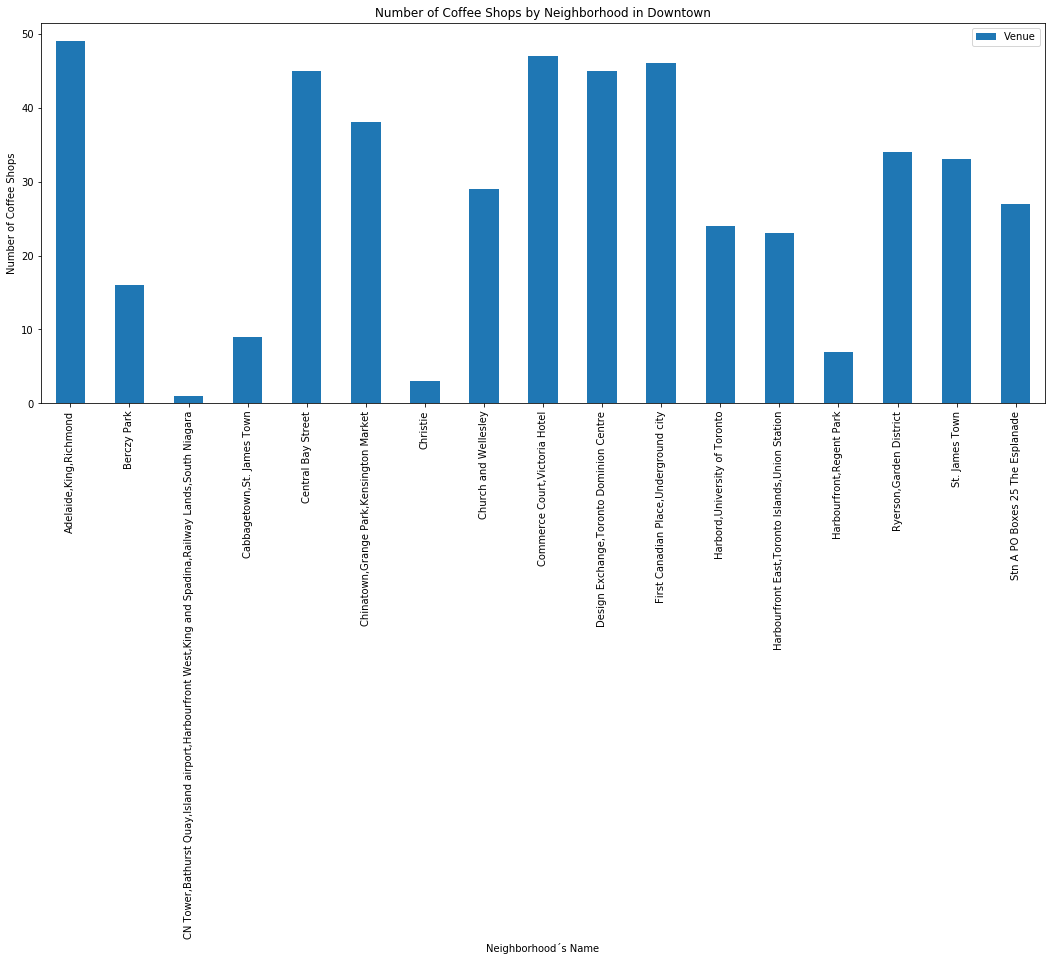

In [285]:
to_venues_downtown_grouped.plot(kind='bar', figsize=(18, 7))

plt.title('Number of Coffee Shops by Neighborhood in Downtown') # add a title to the histogram
plt.ylabel('Number of Coffee Shops') # add y-label
plt.xlabel('Neighborhood´s Name') # add x-label

plt.show()

From the map and the barchart, we see that a hotspot exist in the center of the borough. Now, we narrow down our study to select the neighbors with at least 20 venue records:

In [286]:
to_venues_downtown_grouped=to_venues_downtown_grouped[to_venues_downtown_grouped['Venue']>20]
to_venues_downtown_grouped

,Venue
Neighborhood,
"Adelaide,King,Richmond",49
Central Bay Street,45
"Chinatown,Grange Park,Kensington Market",38
Church and Wellesley,29
"Commerce Court,Victoria Hotel",47
"Design Exchange,Toronto Dominion Centre",45
"First Canadian Place,Underground city",46
"Harbord,University of Toronto",24
"Harbourfront East,Toronto Islands,Union Station",23


In [293]:
to_venues_downtown_grouped.reset_index(inplace=True)

In [294]:
to_downtown_test_list=to_venues_downtown_grouped['Neighborhood']

In [494]:
to_data.set_index('Neighborhood',inplace=True)

In [367]:
to_downtown_test=to_data.loc[[item for item in to_downtown_test_list]]
to_downtown_test=to_downtown_test[to_downtown_test['Borough']=='Downtown Toronto']
to_downtown_test.reset_index(inplace=True)
to_downtown_test.drop(columns=['PostalCode'],inplace=True,axis=0)
to_downtown_test

,Neighborhood,Borough,Latitude,Longitude
0,"Adelaide,King,Richmond",Downtown Toronto,43.650571,-79.384568
1,Central Bay Street,Downtown Toronto,43.657952,-79.387383
2,"Chinatown,Grange Park,Kensington Market",Downtown Toronto,43.653206,-79.400049
3,Church and Wellesley,Downtown Toronto,43.665860,-79.383160
4,"Commerce Court,Victoria Hotel",Downtown Toronto,43.648198,-79.379817
5,"Design Exchange,Toronto Dominion Centre",Downtown Toronto,43.647177,-79.381576
6,"First Canadian Place,Underground city",Downtown Toronto,43.648429,-79.382280
7,"Harbord,University of Toronto",Downtown Toronto,43.662696,-79.400049
8,"Harbourfront East,Toronto Islands,Union Station",Downtown Toronto,43.640816,-79.381752
9,"Ryerson,Garden District",Downtown Toronto,43.657162,-79.378937


Finally we retrieve all nearby venues data from the API for the above neighborhoods:

In [319]:
to_downtown_test_venues=getNearbyVenues2(borough=to_downtown_test['Borough'],names=to_downtown_test['Neighborhood'],
                                   latitudes=to_downtown_test['Latitude'],
                                   longitudes=to_downtown_test['Longitude'])

Adelaide,King,Richmond
Central Bay Street
Chinatown,Grange Park,Kensington Market
Church and Wellesley
Commerce Court,Victoria Hotel
Design Exchange,Toronto Dominion Centre
First Canadian Place,Underground city
Harbord,University of Toronto
Harbourfront East,Toronto Islands,Union Station
Ryerson,Garden District
St. James Town
Stn A PO Boxes 25 The Esplanade


In [492]:
to_downtown_test_venues.head()

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Downtown Toronto,"Adelaide,King,Richmond",43.650571,-79.384568,Four Seasons Centre for the Performing Arts,43.650592,-79.385806,Concert Hall
1,Downtown Toronto,"Adelaide,King,Richmond",43.650571,-79.384568,Nathan Phillips Square,43.652270,-79.383516,Plaza
2,Downtown Toronto,"Adelaide,King,Richmond",43.650571,-79.384568,The Keg Steakhouse & Bar,43.649937,-79.384196,Steakhouse
3,Downtown Toronto,"Adelaide,King,Richmond",43.650571,-79.384568,Shangri-La Toronto,43.649129,-79.386557,Hotel
4,Downtown Toronto,"Adelaide,King,Richmond",43.650571,-79.384568,Rosalinda,43.650252,-79.385156,Vegetarian / Vegan Restaurant


### 2. Clustering

We use the ny_manhattan_test_venues and to_downtown_test_venues as our test dataframesfor the clustering method. First we need to concatenate the dataframes to categorize neighbors across the cities:

In [368]:
frames1=[ny_manhattan_test,to_downtown_test]
combined_neighborhoods=pd.concat(frames1)

In [373]:
frames2=[ny_manhattan_test_venues,to_downtown_test_venues]
test_data=pd.concat(frames)

In [374]:
print(test_data.shape)
test_data.head()

(3286, 8)


,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Manhattan,Chelsea,40.744035,-74.003116,Milk & Hops Chelsea,40.744751,-74.002595,Beer Bar
1,Manhattan,Chelsea,40.744035,-74.003116,Atlantic Theater Company (Linda Gross Theater),40.743953,-74.001476,Theater
2,Manhattan,Chelsea,40.744035,-74.003116,Bathtub Gin,40.743638,-74.003290,Speakeasy
3,Manhattan,Chelsea,40.744035,-74.003116,TAO Downtown,40.742545,-74.003837,Asian Restaurant
4,Manhattan,Chelsea,40.744035,-74.003116,Dil-e Punjab Deli,40.744845,-74.002528,Indian Restaurant


In order to the KMeans method to work, we need to transform the venue categories into a boolean variable:

In [375]:
# one hot encoding
test_data_onehot = pd.get_dummies(test_data[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
test_data_onehot['Neighborhood'] = test_data['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [test_data_onehot.columns[-1]] + list(test_data_onehot.columns[:-1])
test_data_onehot = test_data_onehot[fixed_columns]

test_data_onehot.head()

,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,...,Video Game Store,Vietnamese Restaurant,Volleyball Court,Watch Shop,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [376]:
test_data_onehot.shape

(3286, 319)

Some descriptive statistics of our dataframe:

In [377]:
test_data_grouped = test_data_onehot.groupby('Neighborhood').mean().reset_index()
test_data_grouped

,Neighborhood,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,...,Video Game Store,Vietnamese Restaurant,Volleyball Court,Watch Shop,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,"Adelaide,King,Richmond",0.000000,0.00,0.000000,0.000000,0.040000,0.000000,0.00,0.00,0.00,...,0.000000,0.000000,0.00,0.00,0.00,0.00,0.010000,0.00,0.000000,0.00
1,Central Bay Street,0.011364,0.00,0.000000,0.000000,0.011364,0.000000,0.00,0.00,0.00,...,0.000000,0.000000,0.00,0.00,0.00,0.00,0.011364,0.00,0.000000,0.00
2,Chelsea,0.000000,0.00,0.000000,0.000000,0.040000,0.010000,0.00,0.00,0.00,...,0.000000,0.000000,0.00,0.00,0.00,0.00,0.000000,0.02,0.000000,0.01
3,Chinatown,0.000000,0.00,0.000000,0.000000,0.040000,0.000000,0.00,0.00,0.00,...,0.000000,0.040000,0.00,0.00,0.00,0.00,0.000000,0.00,0.000000,0.00
4,"Chinatown,Grange Park,Kensington Market",0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,...,0.000000,0.030000,0.00,0.00,0.00,0.00,0.010000,0.00,0.000000,0.00
5,Church and Wellesley,0.011364,0.00,0.011364,0.011364,0.011364,0.000000,0.00,0.00,0.00,...,0.011364,0.011364,0.00,0.00,0.00,0.00,0.000000,0.00,0.011364,0.00
6,Civic Center,0.030000,0.00,0.000000,0.000000,0.030000,0.010000,0.00,0.00,0.00,...,0.000000,0.000000,0.00,0.00,0.00,0.00,0.010000,0.01,0.010000,0.00
7,Clinton,0.000000,0.00,0.000000,0.000000,0.040000,0.000000,0.00,0.00,0.00,...,0.000000,0.000000,0.00,0.00,0.00,0.00,0.020000,0.03,0.000000,0.00
8,"Commerce Court,Victoria Hotel",0.000000,0.00,0.000000,0.000000,0.040000,0.000000,0.00,0.00,0.00,...,0.000000,0.000000,0.00,0.00,0.00,0.00,0.010000,0.00,0.000000,0.00
9,"Design Exchange,Toronto Dominion Centre",0.000000,0.00,0.000000,0.000000,0.030000,0.000000,0.00,0.00,0.00,...,0.000000,0.000000,0.00,0.00,0.00,0.00,0.010000,0.00,0.000000,0.00


In [378]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [379]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
test_data_venues_sorted = pd.DataFrame(columns=columns)
test_data_venues_sorted['Neighborhood'] = test_data_grouped['Neighborhood']

for ind in np.arange(test_data_grouped.shape[0]):
    test_data_venues_sorted.iloc[ind, 1:] = return_most_common_venues(test_data_grouped.iloc[ind, :], num_top_venues)

test_data_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide,King,Richmond",Coffee Shop,Café,Steakhouse,Thai Restaurant,American Restaurant,Bar,Burger Joint,Bakery,Hotel,Gym
1,Central Bay Street,Coffee Shop,Café,Italian Restaurant,Burger Joint,Chinese Restaurant,Ice Cream Shop,Spa,Middle Eastern Restaurant,Sushi Restaurant,Japanese Restaurant
2,Chelsea,Coffee Shop,Italian Restaurant,Ice Cream Shop,Nightclub,American Restaurant,Bakery,Seafood Restaurant,Hotel,Theater,Market
3,Chinatown,Chinese Restaurant,American Restaurant,Vietnamese Restaurant,Cocktail Bar,Dumpling Restaurant,Bubble Tea Shop,Bar,Ice Cream Shop,Noodle House,Optical Shop
4,"Chinatown,Grange Park,Kensington Market",Café,Vegetarian / Vegan Restaurant,Bar,Dumpling Restaurant,Mexican Restaurant,Coffee Shop,Bakery,Chinese Restaurant,Vietnamese Restaurant,Burger Joint
5,Church and Wellesley,Coffee Shop,Japanese Restaurant,Gay Bar,Sushi Restaurant,Restaurant,Pub,Bubble Tea Shop,Gastropub,Café,Nightclub
6,Civic Center,Italian Restaurant,Gym / Fitness Center,Sandwich Place,Coffee Shop,French Restaurant,Bakery,Cocktail Bar,Sporting Goods Shop,Yoga Studio,Spa
7,Clinton,Theater,Gym / Fitness Center,American Restaurant,Italian Restaurant,Hotel,Wine Shop,Spa,Cocktail Bar,Food Court,Indie Theater
8,"Commerce Court,Victoria Hotel",Coffee Shop,Café,Hotel,Restaurant,American Restaurant,Gastropub,Deli / Bodega,Bakery,Italian Restaurant,Steakhouse
9,"Design Exchange,Toronto Dominion Centre",Coffee Shop,Café,Hotel,Restaurant,Italian Restaurant,Seafood Restaurant,Gastropub,Deli / Bodega,American Restaurant,Steakhouse


Finally we train our method with the test data set, and analize each cluster:

In [474]:
# set number of clusters
kclusters = 5

test_data_grouped_clustering = test_data_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(test_data_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 0, 3, 3, 3, 0, 0, 1, 1], dtype=int32)

In [475]:
test_data_venues_sorted.drop('Cluster Labels',axis=1,inplace=True)
# add clustering labels
test_data_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

test_data_merged = combined_neighborhoods

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
test_data_merged = test_data_merged.join(test_data_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

test_data_merged.head() # check the last columns!

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Chelsea,Manhattan,40.744035,-74.003116,0,Coffee Shop,Italian Restaurant,Ice Cream Shop,Nightclub,American Restaurant,Bakery,Seafood Restaurant,Hotel,Theater,Market
1,Chinatown,Manhattan,40.715618,-73.994279,3,Chinese Restaurant,American Restaurant,Vietnamese Restaurant,Cocktail Bar,Dumpling Restaurant,Bubble Tea Shop,Bar,Ice Cream Shop,Noodle House,Optical Shop
2,Civic Center,Manhattan,40.715229,-74.005415,0,Italian Restaurant,Gym / Fitness Center,Sandwich Place,Coffee Shop,French Restaurant,Bakery,Cocktail Bar,Sporting Goods Shop,Yoga Studio,Spa
3,Clinton,Manhattan,40.759101,-73.996119,0,Theater,Gym / Fitness Center,American Restaurant,Italian Restaurant,Hotel,Wine Shop,Spa,Cocktail Bar,Food Court,Indie Theater
4,East Village,Manhattan,40.727847,-73.982226,3,Bar,Wine Bar,Pizza Place,Chinese Restaurant,Mexican Restaurant,Ice Cream Shop,Ramen Restaurant,Vegetarian / Vegan Restaurant,Coffee Shop,Cocktail Bar


#### First cluster

In [476]:
test_data_merged.loc[test_data_merged['Cluster Labels'] == 0, test_data_merged.columns[[0]+[1] + list(range(5, test_data_merged.shape[1]))]]

,Neighborhood,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Chelsea,Manhattan,Coffee Shop,Italian Restaurant,Ice Cream Shop,Nightclub,American Restaurant,Bakery,Seafood Restaurant,Hotel,Theater,Market
2,Civic Center,Manhattan,Italian Restaurant,Gym / Fitness Center,Sandwich Place,Coffee Shop,French Restaurant,Bakery,Cocktail Bar,Sporting Goods Shop,Yoga Studio,Spa
3,Clinton,Manhattan,Theater,Gym / Fitness Center,American Restaurant,Italian Restaurant,Hotel,Wine Shop,Spa,Cocktail Bar,Food Court,Indie Theater
7,Gramercy,Manhattan,Italian Restaurant,Bagel Shop,Cocktail Bar,Pizza Place,American Restaurant,Thrift / Vintage Store,Thai Restaurant,Bar,Coffee Shop,Hotel
8,Greenwich Village,Manhattan,Italian Restaurant,French Restaurant,Sushi Restaurant,Clothing Store,Indian Restaurant,Seafood Restaurant,Café,Gym,Electronics Store,Dessert Shop
9,Lenox Hill,Manhattan,Coffee Shop,Sushi Restaurant,Italian Restaurant,Pizza Place,Gym / Fitness Center,Gym,Sporting Goods Shop,Burger Joint,Turkish Restaurant,Deli / Bodega
10,Lincoln Square,Manhattan,Gym / Fitness Center,Theater,Concert Hall,Café,Plaza,Italian Restaurant,Performing Arts Venue,Opera House,French Restaurant,Indie Movie Theater
14,Murray Hill,Manhattan,Coffee Shop,Japanese Restaurant,Hotel,Sandwich Place,French Restaurant,Gym,Bar,Italian Restaurant,Burger Joint,Mediterranean Restaurant
15,Noho,Manhattan,Italian Restaurant,French Restaurant,Cocktail Bar,Coffee Shop,Boutique,Grocery Store,Hotel,Gift Shop,Art Gallery,Mexican Restaurant
17,Sutton Place,Manhattan,Gym / Fitness Center,Italian Restaurant,Indian Restaurant,Furniture / Home Store,American Restaurant,Juice Bar,Dessert Shop,Gym,Pilates Studio,Mexican Restaurant


#### Second cluster

In [477]:
test_data_merged.loc[test_data_merged['Cluster Labels'] == 1, test_data_merged.columns[[0]+[1] + list(range(5, test_data_merged.shape[1]))]]

,Neighborhood,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Financial District,Manhattan,Coffee Shop,Hotel,Wine Shop,Steakhouse,Gym,Gym / Fitness Center,Pizza Place,Café,Bar,Italian Restaurant
0,"Adelaide,King,Richmond",Downtown Toronto,Coffee Shop,Café,Steakhouse,Thai Restaurant,American Restaurant,Bar,Burger Joint,Bakery,Hotel,Gym
1,Central Bay Street,Downtown Toronto,Coffee Shop,Café,Italian Restaurant,Burger Joint,Chinese Restaurant,Ice Cream Shop,Spa,Middle Eastern Restaurant,Sushi Restaurant,Japanese Restaurant
4,"Commerce Court,Victoria Hotel",Downtown Toronto,Coffee Shop,Café,Hotel,Restaurant,American Restaurant,Gastropub,Deli / Bodega,Bakery,Italian Restaurant,Steakhouse
5,"Design Exchange,Toronto Dominion Centre",Downtown Toronto,Coffee Shop,Café,Hotel,Restaurant,Italian Restaurant,Seafood Restaurant,Gastropub,Deli / Bodega,American Restaurant,Steakhouse
6,"First Canadian Place,Underground city",Downtown Toronto,Café,Coffee Shop,Hotel,Steakhouse,Seafood Restaurant,Bar,Restaurant,Burger Joint,Bakery,American Restaurant
8,"Harbourfront East,Toronto Islands,Union Station",Downtown Toronto,Coffee Shop,Hotel,Aquarium,Café,Italian Restaurant,Brewery,Scenic Lookout,Fried Chicken Joint,Restaurant,Bakery
10,St. James Town,Downtown Toronto,Coffee Shop,Hotel,Café,Restaurant,Cosmetics Shop,Breakfast Spot,Bakery,Italian Restaurant,Gastropub,Clothing Store
11,Stn A PO Boxes 25 The Esplanade,Downtown Toronto,Coffee Shop,Restaurant,Café,Hotel,Seafood Restaurant,Cocktail Bar,Beer Bar,Farmers Market,Fast Food Restaurant,Bakery


#### Third cluster

In [478]:
test_data_merged.loc[test_data_merged['Cluster Labels'] == 2, test_data_merged.columns[[0]+[1] + list(range(5, test_data_merged.shape[1]))]]

,Neighborhood,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,Midtown South,Manhattan,Korean Restaurant,Hotel,Coffee Shop,Hotel Bar,Japanese Restaurant,Italian Restaurant,Gym / Fitness Center,Cosmetics Shop,Bakery,American Restaurant


#### Fourth cluster

In [479]:
test_data_merged.loc[test_data_merged['Cluster Labels'] == 3, test_data_merged.columns[[0]+[1] + list(range(5, test_data_merged.shape[1]))]]

,Neighborhood,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Chinatown,Manhattan,Chinese Restaurant,American Restaurant,Vietnamese Restaurant,Cocktail Bar,Dumpling Restaurant,Bubble Tea Shop,Bar,Ice Cream Shop,Noodle House,Optical Shop
4,East Village,Manhattan,Bar,Wine Bar,Pizza Place,Chinese Restaurant,Mexican Restaurant,Ice Cream Shop,Ramen Restaurant,Vegetarian / Vegan Restaurant,Coffee Shop,Cocktail Bar
6,Flatiron,Manhattan,Yoga Studio,American Restaurant,Gym,Gym / Fitness Center,Japanese Restaurant,Sporting Goods Shop,Bakery,Clothing Store,Cosmetics Shop,Cycle Studio
11,Little Italy,Manhattan,Bakery,Seafood Restaurant,Ice Cream Shop,Sandwich Place,Salon / Barbershop,Café,Mediterranean Restaurant,Clothing Store,Italian Restaurant,Massage Studio
12,Midtown,Manhattan,Hotel,Clothing Store,Steakhouse,Theater,Cocktail Bar,Food Truck,Coffee Shop,Sporting Goods Shop,Japanese Restaurant,Bookstore
16,Soho,Manhattan,Clothing Store,Women's Store,Boutique,Men's Store,Shoe Store,Furniture / Home Store,Italian Restaurant,Mediterranean Restaurant,Art Gallery,Café
2,"Chinatown,Grange Park,Kensington Market",Downtown Toronto,Café,Vegetarian / Vegan Restaurant,Bar,Dumpling Restaurant,Mexican Restaurant,Coffee Shop,Bakery,Chinese Restaurant,Vietnamese Restaurant,Burger Joint
3,Church and Wellesley,Downtown Toronto,Coffee Shop,Japanese Restaurant,Gay Bar,Sushi Restaurant,Restaurant,Pub,Bubble Tea Shop,Gastropub,Café,Nightclub
9,"Ryerson,Garden District",Downtown Toronto,Coffee Shop,Clothing Store,Cosmetics Shop,Café,Middle Eastern Restaurant,Bubble Tea Shop,Sporting Goods Shop,Restaurant,Ramen Restaurant,Bakery


#### Fifth cluster

In [480]:
test_data_merged.loc[test_data_merged['Cluster Labels'] == 4, test_data_merged.columns[[0]+[1] + list(range(5, test_data_merged.shape[1]))]]

,Neighborhood,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,"Harbord,University of Toronto",Downtown Toronto,Café,Bar,Restaurant,Bookstore,Bakery,Japanese Restaurant,Beer Bar,Theater,Coffee Shop,Sandwich Place


As seen from avobe, the better neighbors to look at corresponds to the second and fourth clusters, being the second the preferred one. As wee see, this cluster corresponds to finantial neighbors, at last, the coffee consuption of a person working for a finantial company is higher as we can see in the following url site: https://io9.gizmodo.com/here-are-the-fifteen-professions-that-drink-the-most-co-5948206. 

Here they claim that marketing, editors, and financial proffessional consumes higher rates of coffee cups per day as the average person. We can say that even though there are plenty of coffee shops in these area, there are plenty more of proffessionals to consume it. Therefore, it's is plausible to consider that these suggestion is right. To end, we can say that this is only for investigation purpose, it does not reflects the actual state of the coffee shop market in either of the two cities, for that, marketing studies are needed to complement these and other segmentations studies.

#### About me: 
MSc in Physics graduated from the National University of Colombia. With studies in computational electromagnetism and data science. I have knowledge in simulation of electromagnetic systems in CST, databases in SQL, and analysis and visualization of data in Python, Matlab, Mathematica, C / C ++.